In [126]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind, kstest, wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import os
import mne

import sys
sys.path.append('../utils')
from nsl_wavelet_utils import *
from ERP_utils import *
import pickle

In [127]:
fs = 128
n_freqs = 128
frequencies = wavelet_freqs(fs, n_freqs)
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

pos = load_ep_info()
"""ft_l_nmus_pre = loadmat('./matlab_powerdata/y_listen_nmus_pre_power.mat')['y_power']
ft_m_nmus_pre = loadmat('./matlab_powerdata/y_motor_nmus_pre_power.mat') ['y_power']
ft_e_nmus_pre = loadmat('./matlab_powerdata/y_error_nmus_pre_power.mat') ['y_power']"""


"ft_l_nmus_pre = loadmat('./matlab_powerdata/y_listen_nmus_pre_power.mat')['y_power']\nft_m_nmus_pre = loadmat('./matlab_powerdata/y_motor_nmus_pre_power.mat') ['y_power']\nft_e_nmus_pre = loadmat('./matlab_powerdata/y_error_nmus_pre_power.mat') ['y_power']"

In [128]:

# Define the directory and file pattern
directory = './matlab_powerdata/max_ch_good_subs/' 
#directory = './matlab_powerdata/ch_37_old/'

files = [f for f in os.listdir(directory) if f.endswith('.mat')]

# Create a dictionary to store the loaded data
power_dict = {}

# Load the data dynamically
for file in files:
    # Extract the label from the file name
    label = f"ft_{file.split('_')[1]}_{file.split('_')[2]}_{file.split('_')[3]}"

    power_dict[label] = loadmat(os.path.join(directory, file))['y_power'] 

#each key in power_dict is an array of size n_subs, n_channels, n_freqs

In [129]:
power_dict.keys()

dict_keys(['ft_listen_mus_post', 'ft_error_nmus_pre', 'ft_motor_mus_post', 'ft_listen_mus_pre', 'ft_motor_mus_pre', 'ft_listen_nmus_post', 'ft_error_nmus_post', 'ft_motor_nmus_pre', 'ft_motor_nmus_post', 'ft_error_mus_pre', 'ft_error_mus_post', 'ft_listen_nmus_pre'])

In [130]:
#add keys in dictionary to include all participants
for task in ['listen', 'motor','error']:
    for period in ['pre','post']:
        power_dict[f'ft_{task}_all_{period}'] = np.vstack([power_dict[f'ft_{task}_mus_{period}'], power_dict[f'ft_{task}_nmus_{period}']])

### Sanity checks by subject

In [131]:
power_data = power_dict[f'ft_motor_nmus_post']
power_data.shape

(11, 64, 128)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


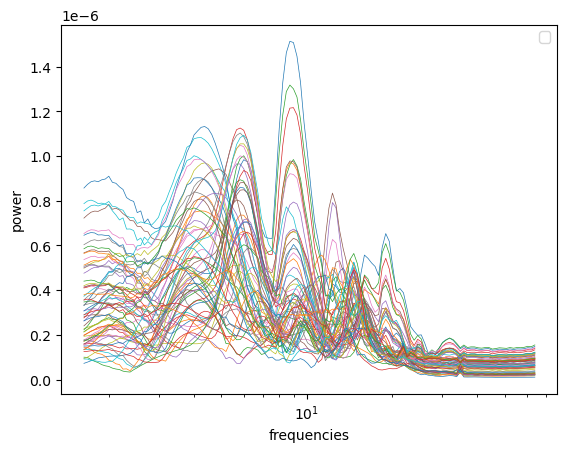

In [132]:
#compare average spectrogram with computing spectrograms individually for each trial
#choose channel to plot
sub = 1



#groups = ['listen_nmus_post', 'motor_nmus_post', 'error_nmus_post']
power_data = power_dict[f'ft_motor_mus_pre']

for ch_idx in range(64):

    power_sub = power_data[sub, ch_idx, :]
    plt.plot(frequencies, power_sub, linewidth = 0.5)

plt.xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()


In [133]:
power_dict.keys()

dict_keys(['ft_listen_mus_post', 'ft_error_nmus_pre', 'ft_motor_mus_post', 'ft_listen_mus_pre', 'ft_motor_mus_pre', 'ft_listen_nmus_post', 'ft_error_nmus_post', 'ft_motor_nmus_pre', 'ft_motor_nmus_post', 'ft_error_mus_pre', 'ft_error_mus_post', 'ft_listen_nmus_pre', 'ft_listen_all_pre', 'ft_listen_all_post', 'ft_motor_all_pre', 'ft_motor_all_post', 'ft_error_all_pre', 'ft_error_all_post'])

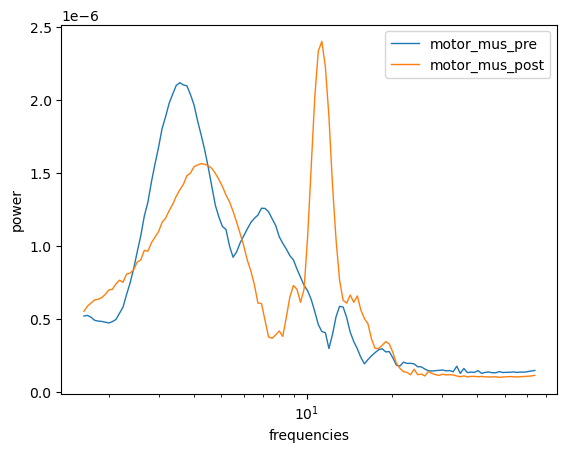

In [134]:
#plotting per subject pre and post

#choose channel to plot
sub = 2


ch_idx = ch_index(['FCz'])[0]

#groups = ['listen_nmus_post', 'motor_nmus_post', 'error_nmus_post']
groups = ['motor_mus_pre','motor_mus_post']

for i, group in enumerate(groups):
    power_data = power_dict[f'ft_{group}']

    power_sub = power_data[sub, ch_idx, :]

    plt.plot(frequencies, power_sub, label = groups[i],linewidth=1)

plt.xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()


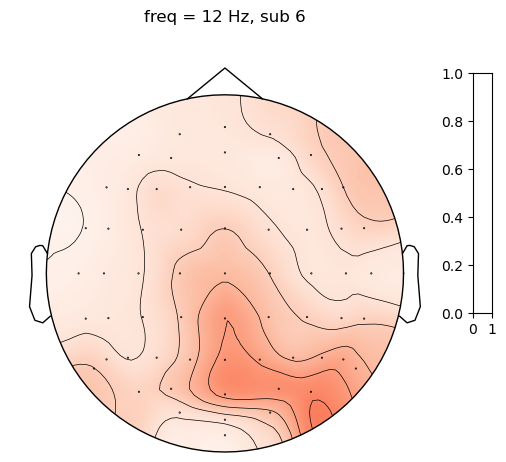

In [135]:
#topomap by subject
sub = 6
freq_toplot = 12
freq_idx = time_index_custom([freq_toplot], frequencies)
vmin = 1e-7
vmax = 2e-6

power_data = np.squeeze(power_dict['ft_motor_mus_post'][sub, :, freq_idx])

fig, ax = plt.subplots()
ax.set_title(f'freq = {freq_toplot} Hz, sub {sub}', pad = 20)
#add colourbar
cbar_ax = fig.add_axes([0.9,0.4,0.03,0.5])


im, cn = mne.viz.plot_topomap(power_data, pos, axes = ax, vlim = (vmin, vmax))
im.set_clim(vmin, vmax)
clb = fig.colorbar(im, cax=cbar_ax)

All subjects overview

In [136]:
power_dict['ft_motor_mus_post'].shape

(7, 64, 128)

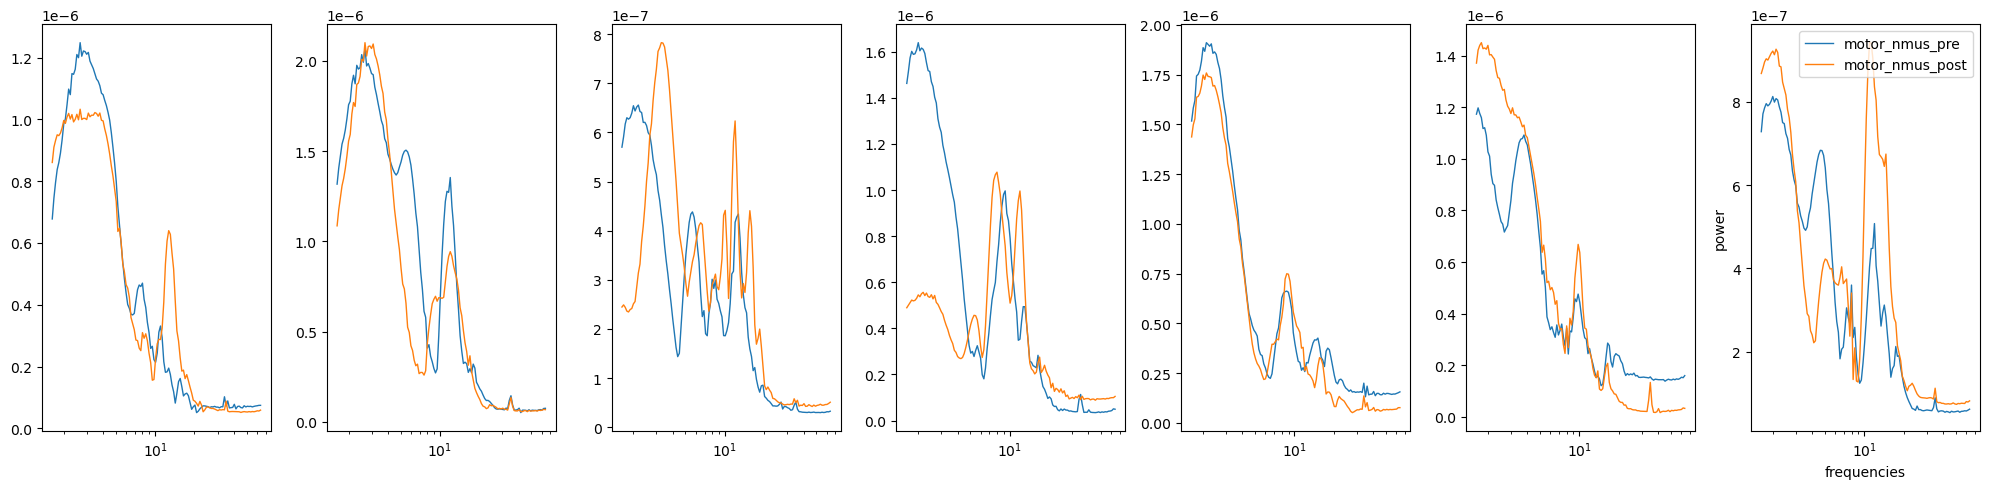

In [137]:
#choose channel to plot
ch_idx = ch_index(['FCz'])[0]
groups = ['motor_nmus_pre','motor_nmus_post']
n_subs = power_dict[f'ft_{group}'].shape[0]

fig, axes = plt.subplots(1, n_subs, figsize = (20,5))
for sub in range(n_subs):

    for i, group in enumerate(groups):
        power_data = power_dict[f'ft_{group}']

        power_sub = power_data[sub, ch_idx, :]

        axes[sub].plot(frequencies, power_sub, label = groups[i],linewidth=1)

        axes[sub].set_xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()
plt.tight_layout()

### Group plots

In [138]:
power_dict['ft_error_mus_post'].shape

(8, 64, 128)

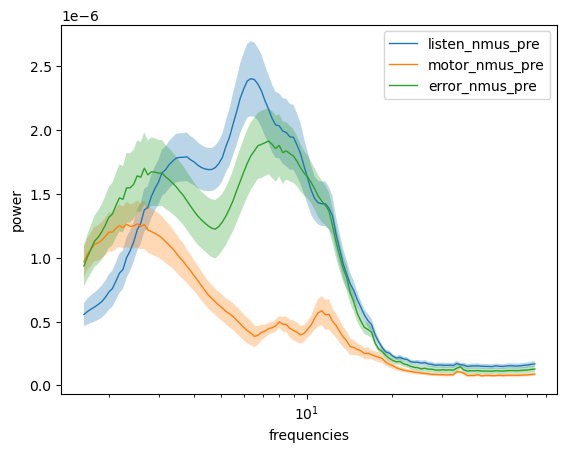

In [139]:

groups = ['listen_nmus_pre', 'motor_nmus_pre', 'error_nmus_pre']
#groups = ['motor_mus_post','motor_nmus_post']

for i, group in enumerate(groups):
    power_data = power_dict[f'ft_{group}']

    mean_power = np.mean(power_data[:, ch_idx, :], axis=0)
    sem_power = np.std(power_data[:, ch_idx, :], axis=0) / np.sqrt(power_data.shape[0])

    plt.plot(frequencies, mean_power, label = groups[i],linewidth=1)
    plt.fill_between(frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)

plt.xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()
#plt.ylim(0, 5e-4)

### Statistics

In [140]:
#choose groups to compare 

groups_tocompare = ['motor_all_pre','motor_all_post']
compare_1 = power_dict[f'ft_{groups_tocompare[0]}']
compare_2 = power_dict[f'ft_{groups_tocompare[1]}']
to_compare = [compare_1, compare_2]

diff_evoked_sa = find_diff_sa(compare_1, compare_2)

In [141]:
def p_times_1sample(array, channels = 'all', tmin = None, tmax = None):
    """ 
    calculate p values of differences between the pre- and post-training ERPs
    uses the 1-sample t-test if normal and wilcoxon otherwise

    array: preprocessed array containing the average ERP (post minus pre) for each subject
    ---
    returns: a list of p values, one p value for each time point
    """
    if channels == 'all':
        print('Calculating p-value over mean of all channels')
        array_ch_mean = array.mean(axis = 1)
    elif type(channels) == list:
        print(f'Calculating p-value over {channels}')
        p_ch_idx = ch_index(channels)
        array = array[:, p_ch_idx]
        array_ch_mean = array.mean(axis = 1)
    else:
        print('Valid channel arguments: type list')
        exit

    #test normality; do 1-sample t-test if normal, wilcoxon otherwise
    ks = gaussian_test(array_ch_mean)



    p_values = []
    for timepoint in range(0, array.shape[2]):
        
        if ks > 0.05:
            res = ttest_1samp(array_ch_mean[:, timepoint], popmean = 0)       

        elif ks < 0.05:
            res = wilcoxon_1samp(array_ch_mean[:, timepoint])        
            print(array_ch_mean[:, timepoint])
            print(res)
        p_values.append(res.pvalue)
    
    n_tests = len(p_values)

    print('p values',p_values)


    if tmin is not None and tmax is not None:
        #FDR correction for multiple comparisons
        start_idx = time_index([tmin])[0]
        end_idx = time_index([tmax])[0]
        end_padding = n_tests-end_idx
        p_values = fdrcorrection(p_values[start_idx:end_idx])[1]

        #pad the array so that it's the right size but everything outside range of interest is 1 so not significant
        p_values = np.pad(p_values,(start_idx, end_padding), constant_values=1)

    else: 
        p_values = fdrcorrection(p_values)[1] #does fdr correction over all timepoints
        #recommend selecting the time slice of interest, otherwise it reduces the power
        

    return p_values

p_within = p_times_1sample(diff_evoked_sa, channels = ['Cz'])

Calculating p-value over ['Cz']
Distribution is not normal. p =  0.00010984673796071755
[ 2.01713444e-07  6.11057175e-09 -1.28620923e-07 -2.69383751e-07
 -2.30425887e-07  3.25442958e-08  4.58104642e-07 -3.59980982e-07
  3.38297801e-07  2.91160611e-07  8.96305840e-07  1.07560095e-07
 -1.90785239e-07 -2.28410648e-07  6.67624493e-09 -6.22947897e-08
  1.44720277e-07  2.30820065e-07]
WilcoxonResult(statistic=68.0, pvalue=0.468292236328125)
[ 2.63149154e-07  1.01781047e-08 -1.44655700e-07 -2.72944777e-07
 -2.47417281e-07  7.81385865e-08  4.76027506e-07 -3.40165380e-07
  3.38205912e-07  3.14106832e-07  9.31104631e-07  1.14709982e-07
 -2.13159343e-07 -2.22813032e-07  1.35842173e-08 -6.01026658e-08
  1.69124826e-07  3.20358869e-07]
WilcoxonResult(statistic=64.0, pvalue=0.3692169189453125)
[ 2.75857343e-07  2.40282626e-08 -1.56499382e-07 -2.69345929e-07
 -2.49375107e-07  8.03496762e-08  4.92934364e-07 -3.24505929e-07
  3.43663336e-07  3.38778875e-07  9.66680890e-07  1.22993095e-07
 -2.45724459e-

In [142]:
compare_1_ch = compare_1[:, 47, :]
compare_2_ch = compare_2[:, 47, :]
diff =  find_diff_sa(compare_1, compare_2)

In [143]:
def p_timelike(array1, array2, chs, test):
    """ 
    Statistics over different timepoints. More flexible than old p calculating functions
    Can also used to compare along the frequencies axis

    array1, array 2: arrays to compare. shape is n_subs, n_channels, n_timepoints
    chs: list of channels to include, or 'all'
    test: 'rel' for within-subs t-test or 'ind' for independent samps t-test
    """

    #initialize
    n_timepoints = array1.shape[2]
    p_values = []

    if chs == 'all':
        array1_sub = np.mean(array1, 1)
        array2_sub = np.mean(array2, 1)
    else:
        ch_idx = ch_index(chs)
        array1_sub = np.mean(array1[:,ch_idx,:], 1) #average over all the included channels
        array2_sub = np.mean(array2[:,ch_idx,:], 1) #average over all the included channels

    ks = gaussian_test(array1_sub)    #guassianity test

    for timepoint in range(n_timepoints):
        array1_time = array1_sub[:, timepoint]
        array2_time = array2_sub[:, timepoint]


        if test == 'rel':
            if ks > 0.05: 
                res = ttest_rel(array1_time, array2_time)
            else: 
                res = wilcoxon(array1_time, array2_time)
        elif test == 'ind':
            if ks > 0.05: 
                res = ttest_ind(array1_time, array2_time)
            else:
                res = mannwhitneyu(array1_time, array2_time)
        
        p_values.append(res.pvalue)


    p_values = np.array(p_values)
    #p_values = fdrcorrection(p_values)[1]

    #fdr correction

    
    #print(p_values)
    return p_values


In [144]:


p_freqs = p_timelike(compare_1, compare_2, ['Cz'], 'rel')


Distribution is not normal. p =  0.00010984597593854102


In [145]:
p_freqs

array([0.46829224, 0.36921692, 0.30379486, 0.28372955, 0.26452637,
       0.26452637, 0.28372955, 0.28372955, 0.28372955, 0.36921692,
       0.36921692, 0.36921692, 0.41711426, 0.49507904, 0.44229889,
       0.41711426, 0.52261353, 0.5508728 , 0.57984161, 0.70188141,
       0.83172607, 0.86504364, 0.83172607, 0.83172607, 0.93228149,
       0.96611786, 0.96611786, 1.        , 0.96611786, 0.79870605,
       0.7337265 , 0.96611786, 0.89857483, 0.7337265 , 0.5508728 ,
       0.5508728 , 0.7337265 , 0.83172607, 0.89857483, 0.79870605,
       0.57984161, 0.76602936, 0.76602936, 0.57984161, 0.79870605,
       0.83172607, 0.96611786, 0.89857483, 0.96611786, 0.89857483,
       0.34654999, 0.19638824, 0.16735077, 0.12973785, 0.1540451 ,
       0.57984161, 0.57984161, 0.18146515, 0.04827881, 0.01040649,
       0.01593018, 0.06653595, 0.12973785, 0.49507904, 1.        ,
       0.96611786, 0.36921692, 0.11870575, 0.10838318, 0.12973785,
       0.07368469, 0.05993652, 0.08142853, 0.08142853, 0.04827

In [146]:
p_sig_idx = np.where(p_freqs<0.05)

In [147]:
p_sig_idx

(array([58, 59, 60, 74, 75]),)

In [148]:
sig_freqs = frequencies[p_sig_idx]

In [149]:
sig_freqs

array([ 8.72406186,  8.97969639,  9.24282157, 13.84858498, 14.25437949])

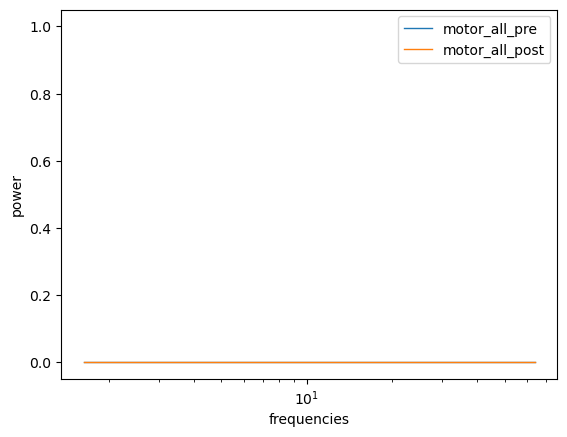

In [150]:
for i, group in enumerate(groups_tocompare):
    power_data = power_dict[f'ft_{group}']

    mean_power = np.mean(power_data[:, ch_idx, :], axis=0)
    sem_power = np.std(power_data[:, ch_idx, :], axis=0) / np.sqrt(power_data.shape[0])

    plt.plot(frequencies, mean_power, label = groups_tocompare[i],linewidth=1)
    plt.fill_between(frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3)

plt.scatter(np.zeros_like(p_freqs), p_freqs)

plt.xscale('log')
plt.xlabel('frequencies')
plt.ylabel('power')
plt.legend()
#plt.ylim(0, 5e-4)

In [151]:
p_freqs

array([0.46829224, 0.36921692, 0.30379486, 0.28372955, 0.26452637,
       0.26452637, 0.28372955, 0.28372955, 0.28372955, 0.36921692,
       0.36921692, 0.36921692, 0.41711426, 0.49507904, 0.44229889,
       0.41711426, 0.52261353, 0.5508728 , 0.57984161, 0.70188141,
       0.83172607, 0.86504364, 0.83172607, 0.83172607, 0.93228149,
       0.96611786, 0.96611786, 1.        , 0.96611786, 0.79870605,
       0.7337265 , 0.96611786, 0.89857483, 0.7337265 , 0.5508728 ,
       0.5508728 , 0.7337265 , 0.83172607, 0.89857483, 0.79870605,
       0.57984161, 0.76602936, 0.76602936, 0.57984161, 0.79870605,
       0.83172607, 0.96611786, 0.89857483, 0.96611786, 0.89857483,
       0.34654999, 0.19638824, 0.16735077, 0.12973785, 0.1540451 ,
       0.57984161, 0.57984161, 0.18146515, 0.04827881, 0.01040649,
       0.01593018, 0.06653595, 0.12973785, 0.49507904, 1.        ,
       0.96611786, 0.36921692, 0.11870575, 0.10838318, 0.12973785,
       0.07368469, 0.05993652, 0.08142853, 0.08142853, 0.04827

In [152]:
frequencies[10]

2.1810154653305154

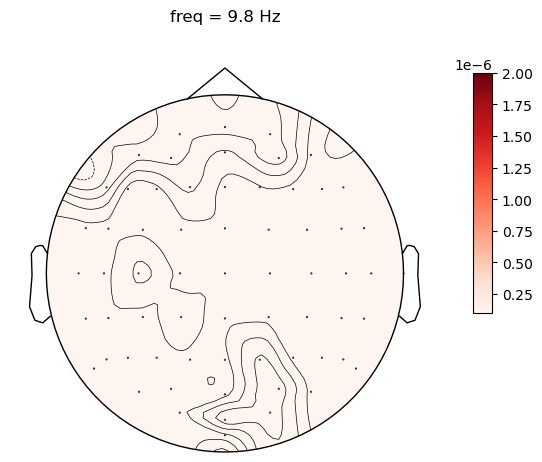

In [153]:
pos = load_ep_info()

freq_toplot = 9.8#Hz
freq_idx = time_index_custom([freq_toplot], frequencies)[0]

arr= p_chs([compare_1, compare_2], time_idx=freq_idx, ttest='rel')
arr = 1-arr #more significant things are more red

fig, axes = plt.subplots()

#add colourbar
cbar_ax = fig.add_axes([0.9,0.4,0.03,0.5])
clb = fig.colorbar(im, cax=cbar_ax)

axes.set_title(f'freq = {freq_toplot} Hz', pad = 20)
im, cn = mne.viz.plot_topomap(arr, pos = pos, vlim = (0.95, 1), axes = axes)

